In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import warnings
import numpy as np
import os
import copy

from torch import optim, nn
from torchvision import datasets, transforms, models
from skimage.segmentation import mark_boundaries
from utils.cat_vs_dog_helpers import *
from PIL import Image
from lime.our_lime import *

In [3]:
def image_transform(imagepath):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.open(imagepath)
    imagetensor = test_transforms(image)
    return imagetensor


def predict(imagepath, model_path, verbose=False):
    if not verbose:
        warnings.filterwarnings('ignore')
    try:
        checks_if_model_is_loaded = type(model)
    except:
        model = load_model(model_path)
    model.eval()
    #summary(model, input_size=(3,244,244))
    if verbose:
        print("Model Loaded..")
    image = image_transform(imagepath)
    image1 = image[None,:,:,:]
    ps=torch.exp(model(image1))
    topconf, topclass = ps.topk(1, dim=1)
    if topclass.item() == 1:
        return {'class':'dog','confidence':str(topconf.item())}
    else:
        return {'class':'cat','confidence':str(topconf.item())}
    

def image_transform_from_numpy(img_array):
    test_transforms = transforms.Compose([transforms.Resize(255),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])
    image = Image.fromarray(np.uint8(img_array*255))
    imagetensor = test_transforms(image)
    return imagetensor

    
def model_to_lime(images):
    try:
        checks_if_model_is_loaded = type(model)
    except:
        model = load_model(model_path)
    model.eval()
    images = torch.stack([image_transform_from_numpy(x) for x in images])
    
    return torch.exp(model(images)).detach().numpy()


def get_image(path):
    with open(path, 'rb') as f:
        with Image.open(f) as img:
            return img.convert('RGB')
        
inv_transform = transforms.Normalize([-0.485/0.229, -0.456/0.224, -0.406/0.225], [1/0.229, 1/0.224, 1/0.225])

In [4]:
dog_img_path = './data/dogs_vs_cats/test/4.jpg'
cat_img_path = './data/dogs_vs_cats/test/5.jpg'
model_path = './data/dogs_vs_cats/catvdog.pth'

{'class': 'dog', 'confidence': '0.9930562376976013'}


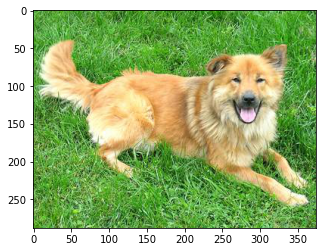

In [5]:
print(predict(dog_img_path, model_path))
plt.imshow(get_image(dog_img_path))

{'class': 'cat', 'confidence': '0.999834418296814'}


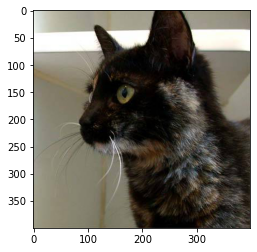

In [6]:
print(predict(cat_img_path, model_path))
plt.imshow(get_image(cat_img_path))

In [7]:
raw_img = get_image(cat_img_path)
img = ImageObject(raw_img)

explainer = Explainer(
    SegmentationMethod("quickshift")
)

explainer.segment_image(img)

In [8]:
def sample_superpixels(self, image, num_samples):
    # sample num_samples collections of superpixels
    num_superpixels = np.unique(image.superpixels).size
    superpixel_samples = np.random.randint(2, size=(num_samples, num_superpixels))

    # apply samlpes to fudged image to generate pertubed images
    sampled_images = list()
    for sample in superpixel_samples:
        sample_masked_image = image.original_image.copy()
        turned_on_superpixels = np.where(sample == 1)[0]
        mask = np.zeros(image.superpixels.shape).astype(bool)
        for superpixel in turned_on_superpixels:  # turn on the sampled pixels
            mask[img.superpixels == superpixel] = True
        sample_masked_image[mask] = image.masked_image[mask]
        sampled_images.append(sample_masked_image)
    return sampled_images
    

In [29]:
image = img
image.original_image = np.array(image.original_image)
num_samples = 10

fudged_img = image.original_image.copy()
fudged_img[:] = 0

sampled_images = list()

# sample num_samples collections of superpixels
num_segments = np.unique(image.superpixels).size
superpixel_samples = np.random.randint(2, size=(num_samples, num_segments))

# apply samlpes to fudged image to generate pertubed images
for sample in superpixel_samples:
    masked_img = image.original_image.copy()
    turned_on_superpixels = np.where(sample == 1)[0]
    mask = np.zeros(image.superpixels.shape).astype(bool)
    for superpixel in turned_on_superpixels:
        mask[img.superpixels == superpixel] = True
    masked_img[mask] = fudged_img[mask]
    sampled_images.append(masked_img)


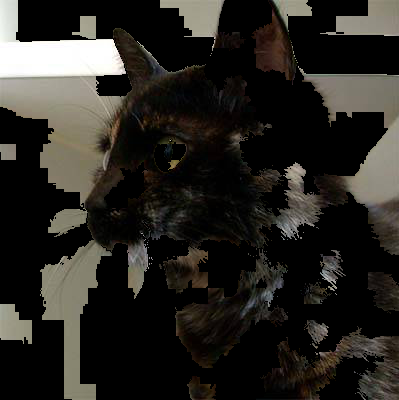

In [35]:
Image.fromarray(sampled_images[4])

In [197]:
img.superpixels

array([[  4,   4,   4, ...,  11,  11,  11],
       [  4,   4,   4, ...,  11,  11,  11],
       [  4,   4,   4, ...,  11,  11,  11],
       ...,
       [158, 158, 158, ..., 174, 174, 174],
       [158, 158, 158, ..., 174, 174, 174],
       [158, 158, 158, ..., 174, 174, 174]], dtype=int64)

In [192]:
np.random.randint(2, size=(num_segments))

array([0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0])

In [177]:
test = np.zeros(img.superpixels.shape).astype(bool)
test[superpixel_samples[1][0]]

array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]])

In [179]:
superpixel_samples[1]

array([ True,  True, False,  True, False, False,  True, False, False,
       False, False, False, False, False,  True, False,  True, False,
        True, False, False,  True,  True,  True,  True,  True, False,
        True,  True, False,  True, False, False,  True, False,  True,
        True, False, False, False, False, False,  True,  True, False,
        True,  True, False, False,  True, False, False,  True, False,
        True, False,  True,  True,  True, False,  True,  True, False,
       False,  True, False, False,  True, False,  True,  True, False,
       False,  True,  True,  True, False, False, False,  True, False,
        True,  True, False, False,  True,  True,  True,  True, False,
       False, False, False,  True, False, False, False, False, False,
        True,  True, False, False, False, False, False, False, False,
        True,  True,  True,  True, False, False, False,  True, False,
       False, False,  True,  True, False,  True, False, False,  True,
        True, False,

In [68]:
num_samples = 100
n_features = np.unique(img.superpixels).shape[0]
data = np.random.randint(0, 2, num_samples * n_features)\
            .reshape((num_samples, n_features))
labels = []
data[0, :] = 1
imgs = []
rows = data
fudged_image = copy.deepcopy(np.array(img.original_image))
fudged_image[:] = 1

for row in rows:
    temp = copy.deepcopy(np.array(img.original_image))
    zeros = np.where(row == 0)[0]
    mask = np.zeros(img.superpixels.shape).astype(bool)
    for z in zeros:
        mask[img.superpixels == z] = True
    temp[mask] = fudged_image[mask]
    imgs.append(temp)

In [183]:
img.superpixels.shape

(400, 399)

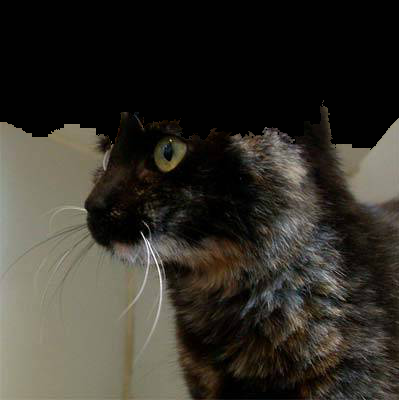

In [159]:
fudged_image = copy.deepcopy(np.array(img.original_image))
temp = copy.deepcopy(np.array(img.original_image))
fudged_image[:] = 1

mask = np.zeros(img.superpixels.shape).astype(bool)
for x in range(55):
    mask[img.superpixels == x] = True
temp[mask] = fudged_image[mask]
Image.fromarray(temp)

In [118]:
imgs[-1].shape

(400, 399, 3)

In [87]:
data.shape

(100, 175)

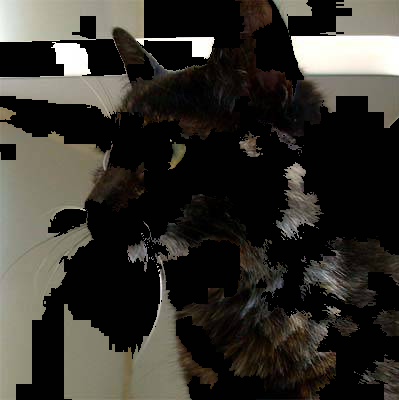

In [97]:
Image.fromarray(imgs[99])

In [23]:
img.superpixels[5]

array([ 4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,  4,
        4,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,
        7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  7,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  5,
        5,  5,  5,  5,  5,  5,  5,  5,  5,  5,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,
        2,  2,  2,  2,  2,  2,  2,  2,  8,  8,  8,  8,  8,  8,  8,  8,  8,
        8,  8,  8,  8,  8,  8,  8,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,  6,
        6,  6, 12, 12, 12

In [15]:
Image.fromarray(np.array(img.original_image)[img.superpixels == 174])

In [9]:
img.superpixels

array([[  4,   4,   4, ...,  11,  11,  11],
       [  4,   4,   4, ...,  11,  11,  11],
       [  4,   4,   4, ...,  11,  11,  11],
       ...,
       [158, 158, 158, ..., 174, 174, 174],
       [158, 158, 158, ..., 174, 174, 174],
       [158, 158, 158, ..., 174, 174, 174]], dtype=int64)

# From lime library

In [10]:
#cat_img_array = np.array(get_image(cat_img_path))
#
#explainer = lime_image.LimeImageExplainer()
#explanation_cat = explainer.explain_instance(
#    cat_img_array, 
#    model_to_lime,
#    top_labels=2,
#    num_samples=1000
#)

In [11]:
#temp, mask = explanation_cat.get_image_and_mask(
#    explanation_cat.top_labels[0], 
#    positive_only=False, 
#    num_features=30, 
#    hide_rest=False
#)
#img_bound = mark_boundaries(temp/255.0, mask)
#plt.imshow(img_bound)

In [12]:
#dog_img_array = np.array(get_image(dog_img_path))
#
#explainer = lime_image.LimeImageExplainer()
#explanation_dog = explainer.explain_instance(
#    dog_img_array, 
#    model_to_lime,
#    top_labels=2,
#    num_samples=1000
#)

In [13]:
#temp, mask = explanation_dog.get_image_and_mask(
#    explanation_dog.top_labels[0], 
#    positive_only=False, 
#    num_features=30, 
#    hide_rest=False
#)
#img_bound = mark_boundaries(temp/255.0, mask)
#plt.imshow(img_bound)